# Downward shortwave radiation at the surface ($SW_d$)

$$
C_{soil} \frac{\partial T_{s}}{\partial t} = (1-\alpha) \cdot \textcolor{red}{SW_d} + LW_d - LW_u \ - H - \lambda E - G      \tag{1.2}
$$

- **Definition:** The total amount of shortwave radiation reaches the land surface.

- **Equation:**

$$
SW_d = S \left( \frac{\overline{d}}{d} \right)^{2} \textrm{cos}(\Theta) \tau_a    \tag{2.1}
$$

where $S$ is the solar constant, $d$ is the distance from the sun to the Earth, $\overline{d}$ is the mean distance from the sun to the Earth, $\Theta$ is the solar zenith angle, and $\tau_a$ is the transmissivity of the atmosphere.

<figure>
  <img src="../_static/images/SWd_01.png">
</figure>

- Provided by radiation scheme.

<br>
<br>
<br>
<hr>

### Solar constant ($S$)

Typically 1365 ~ 1374 W/m<sup>2</sup>.

In [1]:
SOLAR_CONSTANT = 1365  # W/m2

<br>
<br>

### $\overline{d}/d$

In [2]:
import numpy as np
import xarray as xr
import pandas as pd

In [3]:
# Earth-Sun distance correction factor at the summer solstice.

datetime_UTC = pd.Timestamp("2025-06-21T03:00:00")
DAYS_IN_YEAR = 365

# Get day of year
day_of_year = datetime_UTC.dayofyear

# Earth-Sun distance correction factor, d (dimensionless)
# Fractional year in radians
# NOTE: it is highly simplified.
gamma = 2 * np.pi * (day_of_year - 1) / DAYS_IN_YEAR

mean_d_over_d = 1.00011 + 0.034221 * np.cos(gamma) + 0.00128 * np.sin(gamma) \
              + 0.000719 * np.cos(2 * gamma) + 0.000077 * np.sin(2 * gamma)

print('mean(d)/d: ', mean_d_over_d)

mean(d)/d:  0.967442787915536


<br>
<br>

### Solar zenith angle ($\Theta$)

$$
\textrm{cos}(\Theta) = \textrm{sin}(\phi)\textrm{sin}(\delta) + \textrm{cos}(\phi)\textrm{cos}(\delta)\textrm{cos}(h)       \tag{2.2}
$$

where $\phi$ is latitude, $\delta$ is the solar declination angle, and $h$ is the local hour of the sun.

In [ ]:
# Solar zenith angle at SNU Building 501 at the summer solstice.

# lat/lon of SNU Building 501
LAT = 37.46
LON = 126.9483
DAY_OF_SUMMER_SOLSTICE = 173

lat_degree = LAT
lon_degree = LON

# Latitude/longitude in radians
latitude  = lat_degree * np.pi / 180
longitude = lon_degree * np.pi / 180

# Solar declination angle in radians
solar_declination_angle = 23.45 * np.pi / 180 * np.cos(2 * np.pi * (day_of_year - DAY_OF_SUMMER_SOLSTICE) / DAYS_IN_YEAR)

# Local hour angle in radians
local_hour = ( datetime_UTC.hour - 12 ) * np.pi / 12 + longitude

# Calculate the cosine of the zenith angle
cos_zenith = np.sin(latitude) * np.sin(solar_declination_angle) + \
             np.cos(latitude) * np.cos(solar_declination_angle) * np.cos(local_hour)

# avoid negative irradiance
cos_zenith = np.clip(cos_zenith, 0, 1)

print('cosin of solar zenith angle: ', cos_zenith)

cosin of solar zenith angle:  0.9630599043000659


<br>
<br>
<hr>

### Practice 2.1
Plot the global map of solar radiation at the top of the atmosphere, at 12 KST on the summer solstice of 2025.

In [5]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

$$
\textcolor{blue}{SW_{toa}} = S \textcolor{red}{\left( \frac{\overline{d}}{d} \right)}^{2} \textcolor{green}{\textrm{cos}(\Theta)}    \tag{2.3}
$$

In [6]:
def calculate_solar_radiation_toa(lat_degree, lon_degree, datetime_UTC):

    # Get day of year
    day_of_year = datetime_UTC.dayofyear

    # Latitude/longitude in radians
    latitude  = lat_degree * np.pi / 180
    longitude = lon_degree * np.pi / 180

    # GREEN: cos(zenith)
    ### Solar declination angle in radians
    solar_declination_angle = 23.45 * np.pi / 180 * np.cos(2 * np.pi * (day_of_year - DAY_OF_SUMMER_SOLSTICE) / DAYS_IN_YEAR)

    ### Local hour angle in radians
    local_hour = ( datetime_UTC.hour - 12 ) * np.pi / 12 + longitude

    ### Calculate the cosine of the zenith angle|
    cos_zenith = np.sin(latitude) * np.sin(solar_declination_angle) + \
                 np.cos(latitude) * np.cos(solar_declination_angle) * np.cos(local_hour)
    cos_zenith = np.clip(cos_zenith, 0, 1)  # avoid negative irradiance


    # RED: d
    ### Earth-Sun distance correction factor, d (dimensionless)
    ### Fractional year in radians
    gamma = 2 * np.pi * (day_of_year - 1) / DAYS_IN_YEAR

    d = 1.00011 + 0.034221 * np.cos(gamma) + 0.00128 * np.sin(gamma) \
        + 0.000719 * np.cos(2 * gamma) + 0.000077 * np.sin(2 * gamma)

    
    ### BLUE: SW_toa
    # solar radiation at the top of the atmosphere at the given latitude, longitude and time (W/m²)
    solar_radiation_toa = SOLAR_CONSTANT * cos_zenith * d**2

    return solar_radiation_toa

In [7]:
# Calculate solar radiation at the top of the atmosphere at given lat/lon/time.

### Generate a grid of latitudes and longitudes
latitudes  = np.linspace(-90, 90, 180)
longitudes = np.linspace(-180, 180, 360)

### Define time
datetime_UTC = pd.Timestamp("2025-06-21T03:00:00")
# datetime_UTC = pd.Timestamp("2025-07-01T00:00:00")

### Initialize an array for the solar radiation at Top of Atmosphere (TOA)
solar_radiation_toa = np.zeros((len(latitudes), len(longitudes)))

### Calculate longitude averaged TOA solar radiation at the given latitude and time
for i, lat in enumerate(latitudes):
    for j, lon in enumerate(longitudes):
        solar_radiation_toa[i, j] = calculate_solar_radiation_toa(lat, lon, datetime_UTC)

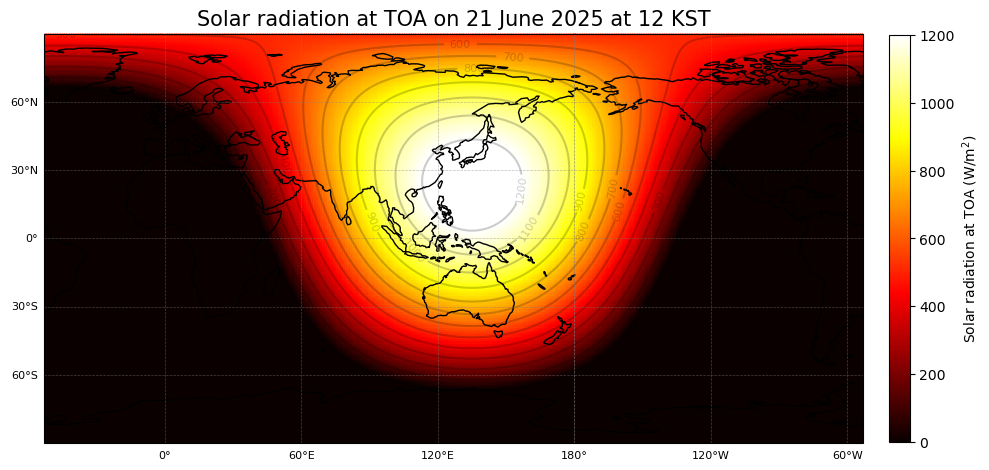

In [8]:
# Plot

### Define function for properties
def add_ticks_for_lat_lon(ax):
    ticks_latlon = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    ticks_latlon.top_labels = False
    ticks_latlon.right_labels = False
    ticks_latlon.xlines = True
    ticks_latlon.ylines = True
    ticks_latlon.xlabel_style = {'size': 8}
    ticks_latlon.ylabel_style = {'size': 8}

fig, ax = plt.subplots(figsize=(10, 7), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=127)})
ax.coastlines(resolution='110m', color='k')
x, y = np.meshgrid(longitudes, latitudes)

### plotting
img = ax.pcolormesh(x, y, solar_radiation_toa, cmap='hot', vmin=0, vmax=1200, transform=ccrs.PlateCarree())
cs  = ax.contour(x, y, solar_radiation_toa, levels=np.arange(0, 1600, 100), colors='black', alpha=0.2, transform=ccrs.PlateCarree())
ax.clabel(cs, inline=True, fontsize=8, fmt='%d')

### properties
cbar = plt.colorbar(img, orientation='vertical', fraction=0.0235, pad=0.03, ax=ax)
cbar.set_ticks([0, 200, 400, 600, 800, 1000, 1200])
cbar.set_label('Solar radiation at TOA (W/m$^{2}$)')
ax.set_title('Solar radiation at TOA on 21 June 2025 at 12 KST', fontsize=15)
add_ticks_for_lat_lon(ax)
plt.tight_layout()

<br>
<br>
<hr>

### $\tau_a$

- The transmissivity is function of water vapor, cloud, aerosols, and as such.
- $\tau_a$ is determined by radiation scheme.
- 0.33 ~ 0.75

In [9]:
# Assume very clear sky condition.
TRANSMISSIVITY = 0.75

<br>
<br>
<hr>

### Practice 2.2
Plot the time series of $SW_d$ in 2025 at SNU Building 501

$$
\textcolor{red}{SW_d} = \textcolor{green}{S \left( \frac{\overline{d}}{d} \right)^{2} \textrm{cos}(\Theta)} \tau_a    \tag{2.1}
$$

In [ ]:
# Calculate solar radiation at the top of the atmosphere at given lat/lon.

datetime_UTC_2025 = pd.date_range("2025-01-01", periods=366, freq='1D')
lat_degree = LAT
lon_degree = LON

### Initialize an array for the solar radiation at Top of Atmosphere (TOA)
solar_radiation_toa = np.zeros(len(datetime_UTC_2025))

### GREEN: Calculate longitude averaged TOA solar radiation at the given latitude and time
for t, datetime_UTC in enumerate(datetime_UTC_2025):
    solar_radiation_toa[t] = calculate_solar_radiation_toa(lat_degree, lon_degree, datetime_UTC)

### RED: Calculate downward solar radiation at the surface
SWd = solar_radiation_toa * TRANSMISSIVITY

<br>

**Plot time series of daily mean $SW_d$**:

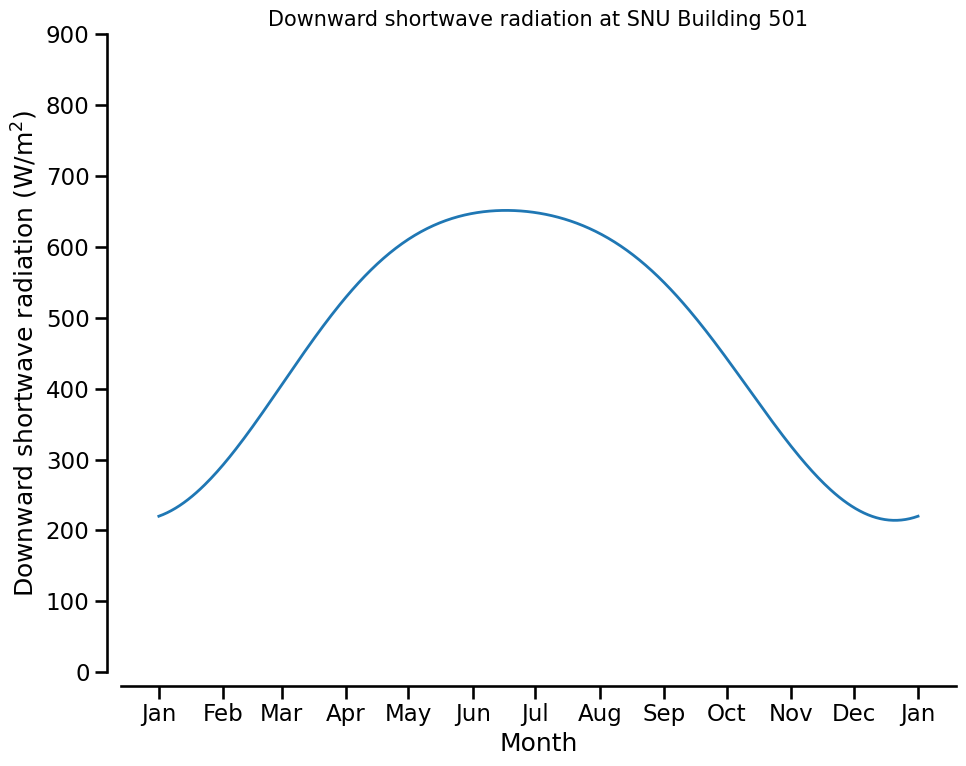

In [11]:
# Plot

import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import cartopy
import cartopy.crs as ccrs

sns.set_context('talk')
fig, ax = plt.subplots(figsize=(10, 8))

# plotting
ax.plot(datetime_UTC_2025, SWd, linewidth=2)

# properties
ax.set_title('Downward shortwave radiation at SNU Building 501', fontsize=15)
ax.set_xlabel('Month', fontsize=18)
ax.xaxis.set_major_locator(mdates.MonthLocator(np.arange(1, 13, 1)))
ax.xaxis.set_major_formatter(DateFormatter("%b"))
ax.set_ylabel('Downward shortwave radiation (W/m$^{2}$)', fontsize=18)
ax.set_ylim(0, 900)

sns.despine(offset=10)
plt.tight_layout()